### Imports

In [39]:
import datetime
import json
import multiprocessing as mp
import pathlib

import joblib
import numpy as np
import pandas as pd
from config import (
    DefaultDecoder,
    DefaultEncoder,
    ElasticParams,
    RSFParams,
)
from matplotlib import pyplot as plt
from metrics import (
    batched_concordance,
    get_variable_impact_auc,
    plot_alphas,
    plot_cda,
    plot_coefficients,
    plot_joint,
    predict_surv_exp_med,
)
from matplotlib.axes import Axes
from preprocessing.pipeline import get_preprocessed_data
from preprocessing.pre_survival import prep_data_for_surv_analysis
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import (
    RandomSurvivalForest,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import (
    as_cumulative_dynamic_auc_scorer,
)

# Read Data

In [40]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [41]:
df["resolution_class"].value_counts()

resolution_class
resolved before police    736174
resolved by police        591522
resolution unknown         86057
failed to respond          75396
Name: count, dtype: int64[pyarrow]

# Random Survival Forest

In [42]:
# HYPERPARAMETERS ##
# see src/config for default parameters
save_name = input(
    "Input a name for this model or leave blank to use a hash of the model results"
)
root_save_dir: pathlib.Path = pathlib.Path("../models/survival_forest/")
# remove_cols = {
#     "descriptor",
#     "resolution_description",
#     "resolution_action_updated_date",
#     "incident_zip",
#     "city",
#     "bbl",
#     "status",
#     "closed_H",
#     "created_date",
#     "closed_date",
#     "sector",
#     "due_date",
#     "date_H",
#     "precip_period_hrs",
#     "precip_accumulation_mm",
#     "direction_deg",
#     "agency",
#     "latitude",
#     "longitude",
#     "year",
# }
chunk_size = 1000
do_predict = True
calc_conc = True
calc_auc = True
assets_path = pathlib.Path(f"../plots/rsf/{save_name}")
if not assets_path.exists():
    assets_path.mkdir()
hyper = RSFParams(year=year, save_name=save_name)
rsf_decoder = DefaultDecoder(RSFParams)

Load model if available (one with the same name is saved) else train new one using data and hyper params


In [43]:
assert 0 < hyper.cpu_prop <= 1
n_jobs = int(mp.cpu_count() * hyper.cpu_prop)
try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=rsf_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    rsf = joblib.load(root_save_dir / f"{save_name}" / "rsf.pickle")
    try:
        scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    except FileNotFoundError:
        X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
            df, ohe_obj=ohe_obj, **hyper.__dict__
        )
        joblib.dump(scaler_obj, save_path / "scaler.pickle")

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )


except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )

    rsf = RandomSurvivalForest(
        hyper.n_estimators,
        max_depth=hyper.max_depth,
        min_samples_leaf=hyper.min_samples_leaf,
        n_jobs=n_jobs,
        random_state=hyper.seed,
        verbose=0
    )
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    joblib.dump(rsf, save_path / "rsf.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=DefaultEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


In [44]:
do_predict = True
calc_conc = True
calc_auc = True

In [45]:
# define time of interest: in this case 25 times between the 5th and 50th percentile
times = np.percentile(np.array([te[1] for te in y_test]), np.linspace(5, 50, 25))

In [46]:
if calc_conc:
    concordance = batched_concordance(rsf, X_test, y_test, chunk_size)
    print(concordance)

100%|██████████| 149/149 [11:44<00:00,  4.73s/it]

0.5134657836644592


100%|██████████| 149/149 [14:32<00:00,  5.86s/it]


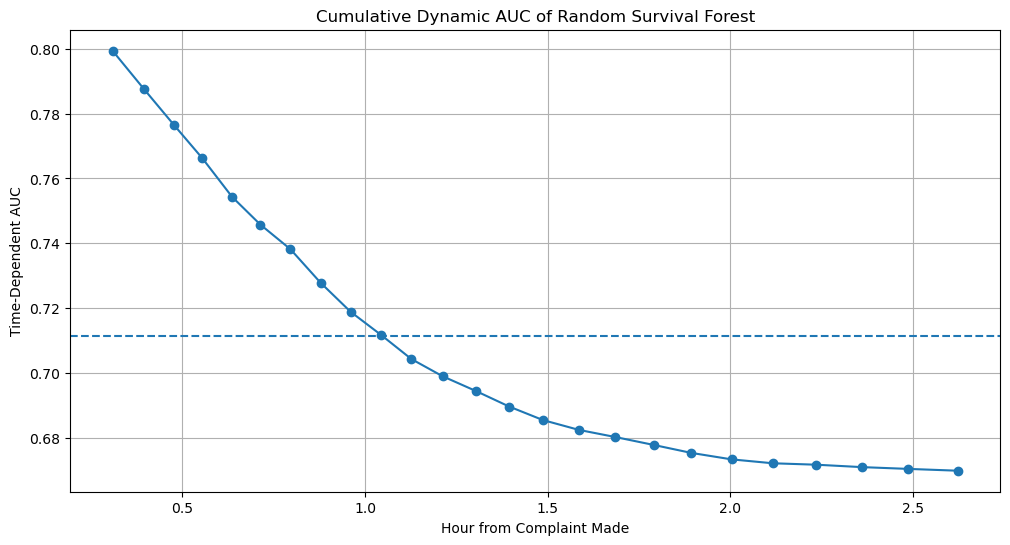

In [47]:
if calc_auc:
    rsf_auc, rsf_mean_auc = plot_cda(rsf, X_test, y_train, y_test, times, save_path=assets_path, model_name="Random Survival Forest", chunk_size=chunk_size)

In [48]:
if do_predict:
    # this may take a while
    pred_exp, pred_med = predict_surv_exp_med(rsf, X_test, chunk_size)
    gt = pd.Series([y[1] for y in y_test], name="hours_to_complete")
    final_df = pd.concat([X_test.reset_index(), gt, pred_exp.reset_index(drop=True), pred_med.reset_index(drop=True)], axis=1)
    final_df["Expected Hours to Complete"] = final_df[0]
    final_df["Median Hours to Complete"] = final_df[1]
    plot_joint(final_df, yvar="Expected Hours to Complete")
    plot_joint(final_df, yvar="Median Hours to Complete", ylab='Predicted Median Time to Close Complaint (hours)')

0it [00:00, ?it/s]

25it [00:13,  1.84it/s]


Saving /home/jackmorris/nypd311/Capstone/src/../plots/rsf/num_cat/Random Survival Forest_top7_cda_impact.png
Saving /home/jackmorris/nypd311/Capstone/src/../plots/rsf/num_cat/Random Survival Forest_bottom7_cda_impact.png


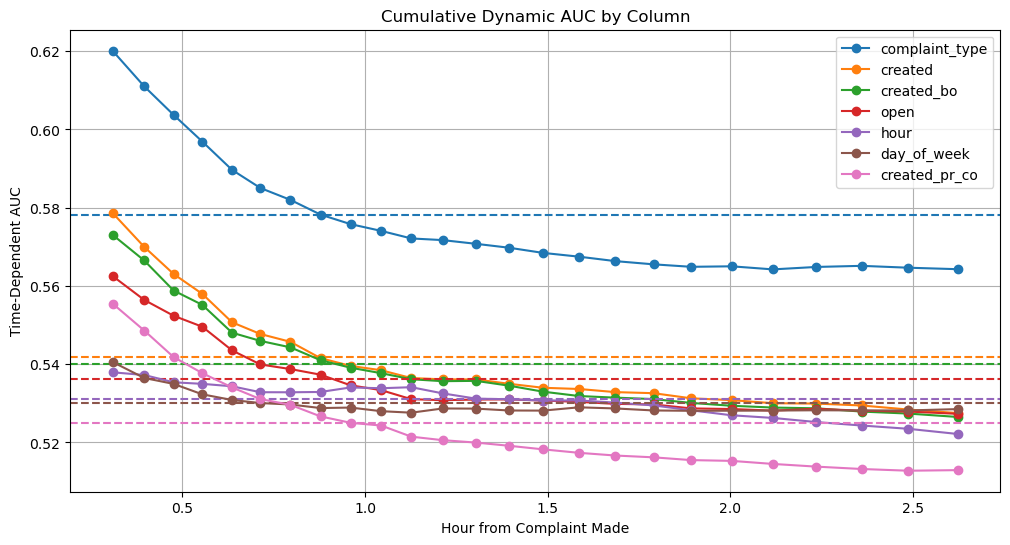

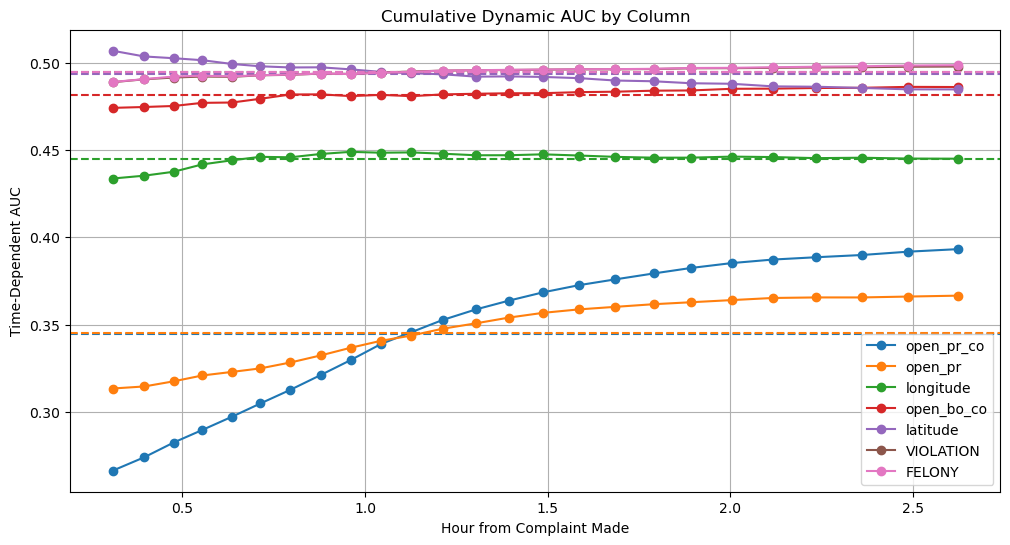

In [49]:
get_variable_impact_auc(
    X_test,
    y_train,
    y_test,
    times,
    assets_path,
    "Random Survival Forest",
    num_cols = 7,
    do_concord = False,
    do_top = True,
    do_bottom = True
)

In [52]:
result = permutation_importance(rsf, X_test[:chunk_size*5], y_test[:chunk_size*5], n_repeats=5, random_state=hyper.seed, max_samples=0.10)



In [57]:

imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [58]:
imp_df.loc[(imp_df['importances_mean'] != 0)].sort_values("importances_mean")

,importances_mean,importances_std
hour,-0.020408,0.000450
created_pr_co,-0.019913,0.000123
open_bo,-0.019892,0.000138
created_bo_co,-0.019804,0.000227
speed_mps,-0.019747,0.000004
open,-0.019741,0.000011
created_co,-0.019738,0.000304
VIOLATION,-0.019736,0.000000
MISDEMEANOR,-0.019736,0.000000
FELONY,-0.019736,0.000000


In [61]:
# low importance features (importance may be 0)
imp_df["low5"] = imp_df["importances_mean"] - imp_df["importances_mean"]*1.96
imp_df["high95"] = imp_df["importances_mean"] + imp_df["importances_mean"]*1.96
imp_df[(imp_df["low5"] <= 0) & (imp_df["high95"] >=0)]

,importances_mean,importances_std,low5,high95
open_pr_co,0.009682,0.003807,-0.009294,0.028658
open_pr,0.006771,0.004275,-0.006500,0.020043


# ElasticNet CPH

In [62]:
## HYPERPARAMETERS ##
hyper = ElasticParams(year=year, save_name=save_name, alpha_min_ratio=0.005)
elas_decoder = DefaultDecoder(ElasticParams)
root_save_dir: pathlib.Path = pathlib.Path("../models/elastic_cph/")
assets_path = pathlib.Path(f"../plots/cph_elastic/{save_name}/")
if not assets_path.exists():
    assets_path.mkdir(parents=True)
if not root_save_dir.exists():
    root_save_dir.mkdir(parents=True)

In [63]:
non_cat = [col for col in df.select_dtypes("int").columns if col[:4] in ("open", "crea")]
df[non_cat] = df[non_cat].astype('float32[pyarrow]')

try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=elas_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    cox_elastic_net = joblib.load(root_save_dir / f"{save_name}" / "cph.pickle")
    scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )

except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )
    # create baseline for selecting alpha
    cox_elastic_net = CoxnetSurvivalAnalysis(
		n_alphas = hyper.n_alphas,
		alphas = hyper.alphas,
		alpha_min_ratio = hyper.alpha_min_ratio,
		l1_ratio = hyper.l1_ratio,
		penalty_factor = hyper.penalty_factor,
		normalize = hyper.normalize,
		copy_X = hyper.copy_X,
		tol = hyper.tol,
		max_iter = hyper.max_iter,
		verbose = hyper.verbose,
		fit_baseline_model = hyper.fit_baseline_model
    )
    cox_elastic_net.fit(X_train, y_train)
    # cox_elastic_net.fit(X_train, y_train)
    coefficients_elastic_net = pd.DataFrame(
        cox_elastic_net.coef_, index=X_train.columns, columns=np.round(cox_elastic_net.alphas_, 10)
    )

    plot_coefficients(coefficients_elastic_net, n_highlight=9)
    estimated_alphas = cox_elastic_net.alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=hyper.seed)
    gcv = GridSearchCV(
        as_cumulative_dynamic_auc_scorer(cox_elastic_net, times=times),
        # CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True),
        param_grid={"estimator__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=n_jobs
    ).fit(X_train, y_train)


    cv_results = pd.DataFrame(gcv.cv_results_)
    alphas = cv_results["param_estimator__alphas"].map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score
    plot_alphas(alphas, mean, std, gcv.best_params_["estimator__alphas"][0])
    model = gcv.best_estimator_.estimator_#.named_steps["coxnetsurvivalanalysis"]
    hyper.alphas = [gcv.best_params_["estimator__alphas"][0]]
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    save_path.mkdir(exist_ok=True)
    joblib.dump(model, save_path / "cph.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=DefaultEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


In [65]:
model = cox_elastic_net.estimator_

Number of non-zero coefficients: 125


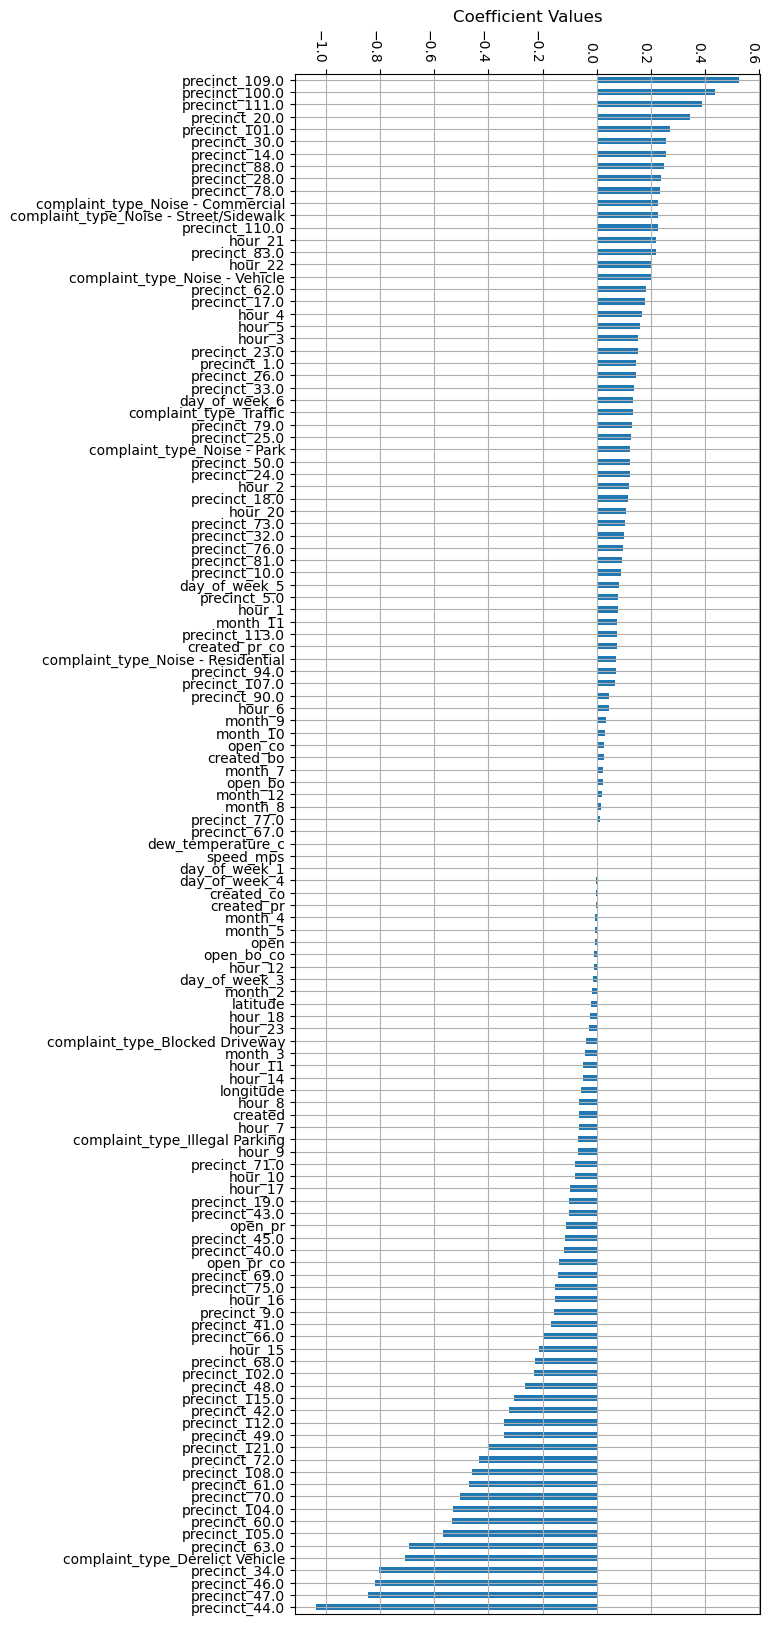

In [66]:

best_coefs = pd.DataFrame(model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.sort_values("coefficient").index
ax:Axes
_, ax = plt.subplots(figsize=(6, 20))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.xaxis.tick_top()
# ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# ax.set_xlabel("Coefficient", )
ax.set_title("Coefficient Values")
plt.xticks(rotation=270, ha='right')
# ax.label_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.grid(True)


245it [02:04,  1.97it/s]


Saving /home/jackmorris/nypd311/Capstone/src/../plots/cph_elastic/num_cat/Elastic Net CPH_top7_cda_impact.png
Saving /home/jackmorris/nypd311/Capstone/src/../plots/cph_elastic/num_cat/Elastic Net CPH_bottom7_cda_impact.png


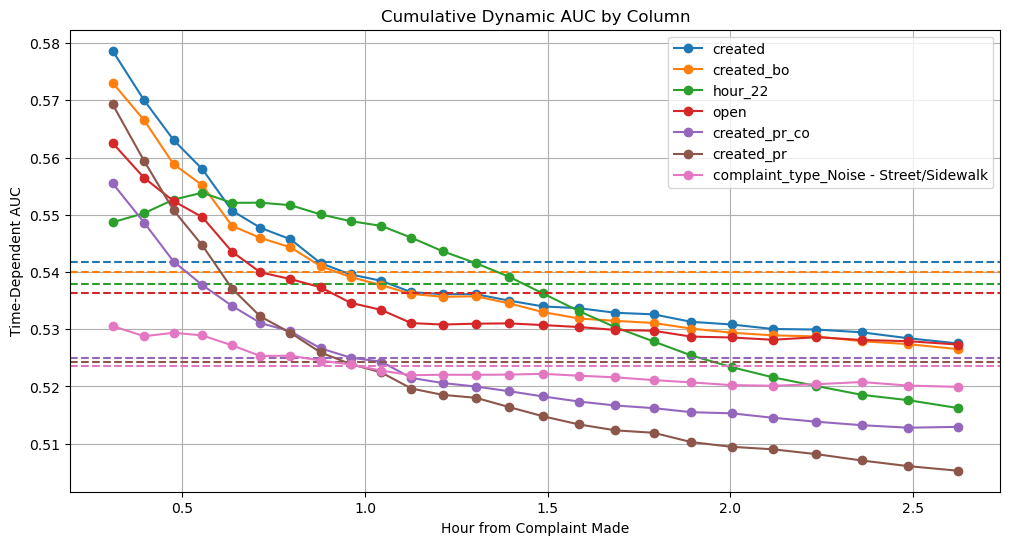

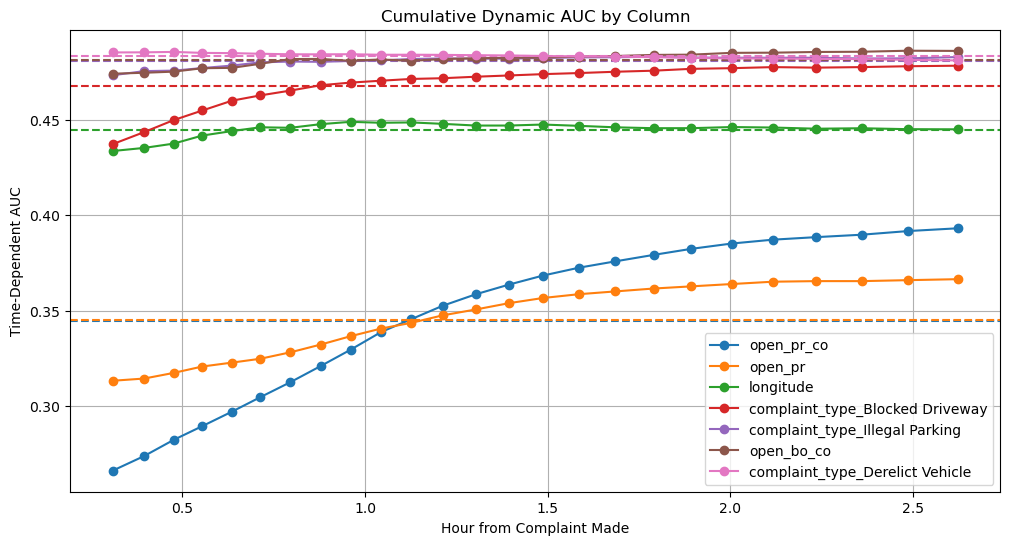

In [37]:
get_variable_impact_auc(
    X_test,
    y_train,
    y_test,
    times,
    assets_path,
    "Elastic Net CPH",
    num_cols = 7,
    do_concord = False,
    do_top = True,
    do_bottom = True
)

100%|██████████| 149/149 [00:39<00:00,  3.82it/s]


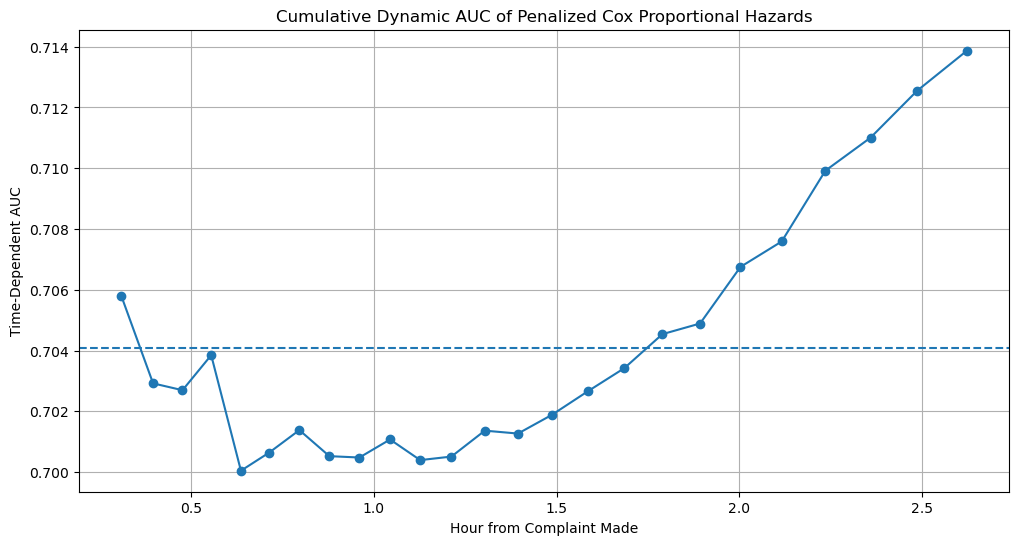

In [74]:

cph_auc, cph_mean_auc = plot_cda(model, X_test, y_train, y_test, times, assets_path, "Penalized Cox Proportional Hazards", chunk_size)

In [75]:
if calc_conc:
    concordance = cox_elastic_net.score(X_test, y_test)
    print(concordance)

0.6621117755402747
